# Time Series Prediction Using LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/MaunaLoaDailyTemps.csv", index_col = "DATE", parse_dates = True)
df

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758
...,...,...,...,...,...
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753


In [ ]:
df.dtypes

MinTemp    float64
MaxTemp    float64
AvgTemp    float64
Sunrise      int64
Sunset       int64
dtype: object

In [ ]:
df.isna().sum()

MinTemp    4
MaxTemp    4
AvgTemp    4
Sunrise    0
Sunset     0
dtype: int64

In [ ]:
df.dropna(axis = 0, inplace = True)
df.isna().sum()

MinTemp    0
MaxTemp    0
AvgTemp    0
Sunrise    0
Sunset     0
dtype: int64

<Axes: xlabel='DATE'>

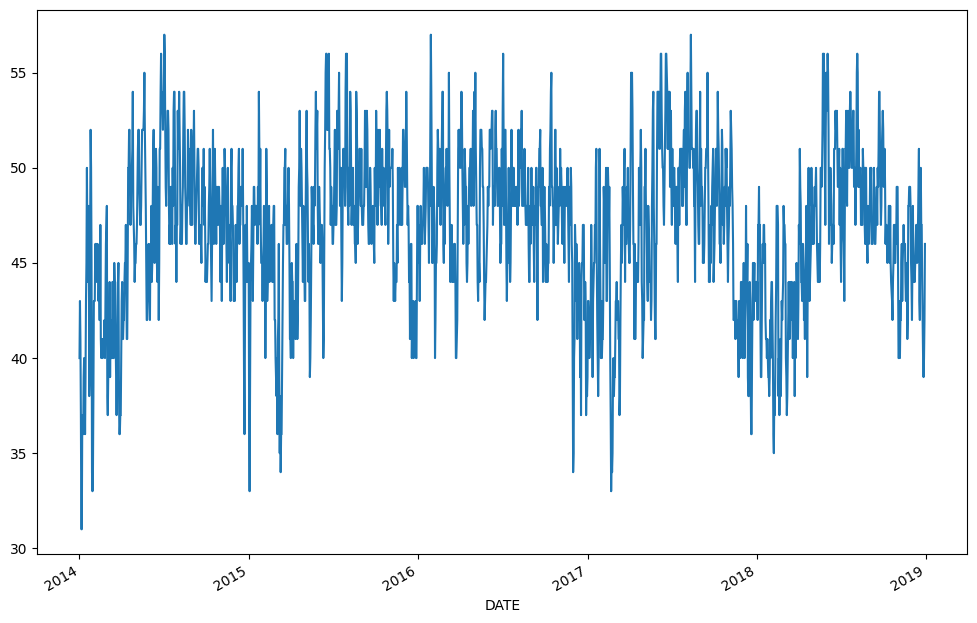

In [ ]:
df["AvgTemp"].plot(figsize = (12, 8))

In [ ]:
df.index = pd.to_datetime(df.index)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
type(df["AvgTemp"])

pandas.core.series.Series

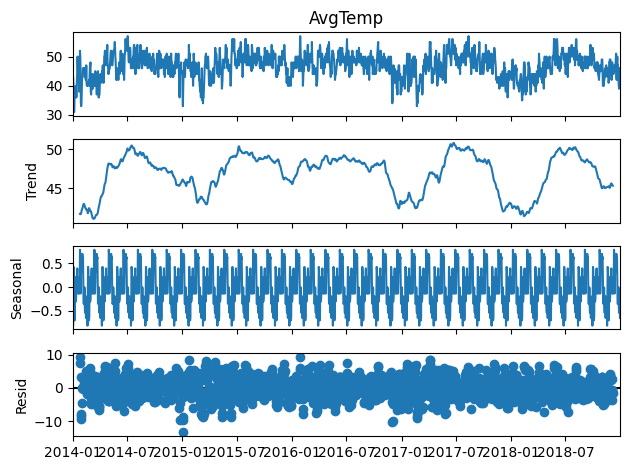

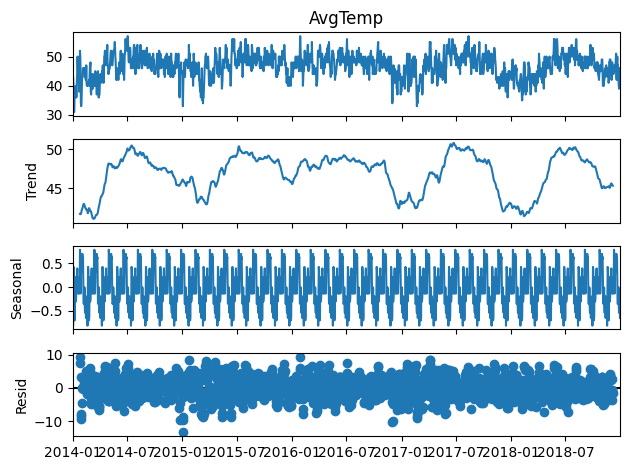

In [ ]:
period = 12*4 # Specify a monthly seasonality
results = seasonal_decompose(df["AvgTemp"], model='additive', period=period)
results.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def ad_test(dataset):
  dftest = adfuller(dataset, autolag = "AIC")
  print("1. ADF: ", dftest[0])
  print("2. P-value: ", dftest[1])
  print("3. Num of lags: ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression:", dftest[3])
  print("5. Critical value: ")
  for key, val in dftest[4].items():
    print("\t", key, ":", val)

In [ ]:
ad_test(df["AvgTemp"])

1. ADF:  -6.554680125068777
2. P-value:  8.675937480199653e-09
3. Num of lags:  12
4. Num Of Observations Used For ADF Regression: 1808
5. Critical value: 
	 1% : -3.433972018026501
	 5% : -2.8631399192826676
	 10% : -2.5676217442756872


In [ ]:
df

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758
...,...,...,...,...,...
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753


In [ ]:
temp = df["AvgTemp"]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

## Scaling the data is recommended for an LSTM model

In [ ]:
def df_to_X_y_scaled(df, window_size=5):
    scaler = MinMaxScaler()
    # Reshape input dataframe to 2D array with a single feature
    df_reshaped = df.values.reshape(-1, 1)
    df_scaled = scaler.fit_transform(df_reshaped)
    X = []
    y = []
    for i in range(len(df_scaled)-window_size):
        row = [[a] for a in df_scaled[i:i+window_size]]
        X.append(row)
        label = df_scaled[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y_scaled(temp, WINDOW_SIZE)
X1.shape, y1.shape

((1818, 3, 1, 1), (1818, 1))

In [ ]:
X_train1, y_train1 = X1[:1200], y1[:1200]
X_val1, y_val1 = X1[1200:1500], y1[1200:1500]
X_test1, y_test1 = X1[1500:], y1[1500:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1200, 3, 1, 1),
 (1200, 1),
 (300, 3, 1, 1),
 (300, 1),
 (318, 3, 1, 1),
 (318, 1))

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

model1 = Sequential()
model1.add(InputLayer((3, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=25, callbacks=[cp1])

Epoch 1/25
38/38 [==============================] - 8s 118ms/step - loss: 0.3769 - root_mean_squared_error: 0.6139 - val_loss: 0.3363 - val_root_mean_squared_error: 0.5799
Epoch 2/25
38/38 [==============================] - 3s 89ms/step - loss: 0.2905 - root_mean_squared_error: 0.5390 - val_loss: 0.2569 - val_root_mean_squared_error: 0.5069
Epoch 3/25
38/38 [==============================] - 3s 81ms/step - loss: 0.2216 - root_mean_squared_error: 0.4708 - val_loss: 0.1967 - val_root_mean_squared_error: 0.4435
Epoch 4/25
38/38 [==============================] - 4s 99ms/step - loss: 0.1669 - root_mean_squared_error: 0.4085 - val_loss: 0.1440 - val_root_mean_squared_error: 0.3795
Epoch 5/25
38/38 [==============================] - 4s 96ms/step - loss: 0.1183 - root_mean_squared_error: 0.3439 - val_loss: 0.0982 - val_root_mean_squared_error: 0.3134
Epoch 6/25
38/38 [==============================] - 3s 80ms/step - loss: 0.0773 - root_mean_squared_error: 0.2781 - val_loss: 0.0613 - val_root_

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
print(y_train1.shape)
print(y_train1.ndim)

(1200, 1)
2


In [ ]:
y_train1 = y_train1.reshape(-1)

In [ ]:
print(y_train1.shape)
print(y_train1.ndim)

(1200,)
1


In [ ]:
train_predictions = model1.predict(X_train1).flatten()
train_predictions = train_predictions.flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

38/38 [==============================] - 1s 3ms/step


,Train Predictions,Actuals
0,0.466559,0.230769
1,0.456453,0.000000
2,0.367707,0.000000
3,0.281034,0.230769
4,0.258066,0.192308
...,...,...
1195,0.502390,0.461538
1196,0.523859,0.538462
1197,0.500984,0.538462
1198,0.539076,0.500000


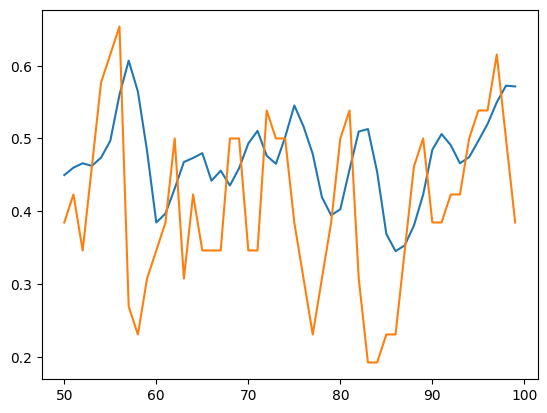

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [ ]:
y_val1 = y_val1.reshape(-1)

In [ ]:
print(y_val1.shape)
print(y_val1.ndim)

(300,)
1


In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,0.545378,0.576923
1,0.547065,0.730769
2,0.589064,0.615385
3,0.627228,0.615385
4,0.643988,0.730769
...,...,...
295,0.351545,0.307692
296,0.384583,0.423077
297,0.408676,0.500000
298,0.465864,0.653846


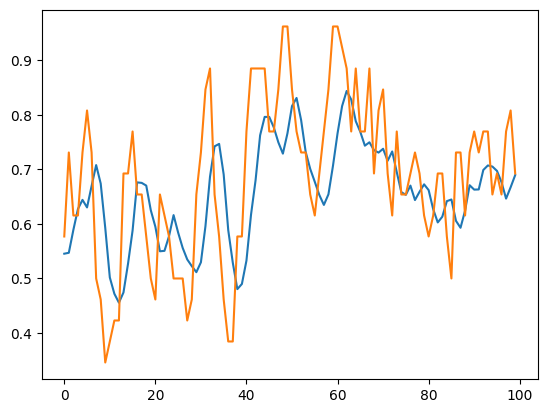

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [ ]:
y_test1 = y_test1.reshape(-1)

In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,0.594280,0.653846
1,0.637387,0.615385
2,0.631150,0.269231
3,0.566392,0.346154
4,0.490380,0.230769
...,...,...
313,0.554278,0.346154
314,0.493330,0.307692
315,0.449769,0.346154
316,0.427027,0.423077


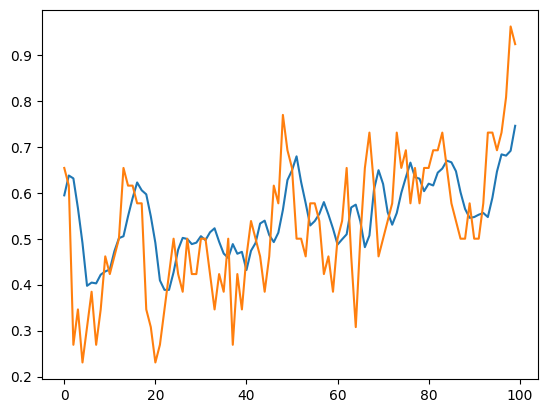

In [ ]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])